In [7]:
from datasets import load_dataset, Dataset, DatasetDict
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import TrainingArguments
from transformers import Trainer

ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")

#processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
#model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Part $1:$ Data Analysis and Preparation:

In [3]:
WIDTH, HEIGHT = 100, 100

def preprocess_function(examples):
    # Load and process images
    images = [image_file.resize((WIDTH, HEIGHT), Image.Resampling.LANCZOS) for image_file in examples['image']]
    # Tokenize captions
    captions = [caption for caption in examples['caption_choices']]
    inputs = processor(images=images, text=captions, return_tensors="pt", padding='max_length', truncation=True)

    # Convert tensors to lists (map expects lists)
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "pixel_values": inputs["pixel_values"],
        "labels": inputs["input_ids"]
    }

# Apply the preprocessing function to the dataset
processed_dataset = ds.map(preprocess_function, batched=True, batch_size=50, remove_columns=ds["train"].column_names)


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

# Part $2:$ Exploratory Data Analysis (EDA)

print(dataset['train'].features)


In [3]:
print(ds['train'].features)


{'image': Image(mode=None, decode=True, id=None), 'contest_number': Value(dtype='int32', id=None), 'image_location': Value(dtype='string', id=None), 'image_description': Value(dtype='string', id=None), 'image_uncanny_description': Value(dtype='string', id=None), 'entities': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'questions': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'caption_choices': Value(dtype='string', id=None), 'from_description': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None), 'n_tokens_label': Value(dtype='int32', id=None), 'instance_id': Value(dtype='string', id=None)}


In [4]:
ds['train'][0]  # single example
#dataset['train'].select(range(3))  # first 3 samples


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=400x288>,
 'contest_number': 130,
 'image_location': 'the yard',
 'image_description': 'Two women are looking out a window. There is snow outside, and there is a snowman with human arms.',
 'image_uncanny_description': 'A snowman has branches for arms, not human arms.',
 'entities': ['https://en.wikipedia.org/wiki/Snowman',
  'https://en.wikipedia.org/wiki/Human'],
 'questions': ['Is there a man stuck inside?'],
 'caption_choices': 'He has a summer job as a scarecrow.',
 'from_description': 'scene: the yard description: Two women are looking out a window. There is snow outside, and there is a snowman with human arms. uncanny: A snowman has branches for arms, not human arms. entities: Snowman, Human. caption: He has a summer job as a scarecrow.',
 'label': "The real man inside of the snowman is apparently the sort of person who will take a seasonal job as a seasonally-appropriate anthropomorphic sculpture, e.g., a snowman in

In [ ]:

def check_missing(split):
    for feature in ds[split].features:
        values = ds[split][feature]
        missing = sum(v is None or v == "" for v in values)
        print(f"{feature}: {missing} missing")

check_missing("train")


image: 0 missing
contest_number: 0 missing
image_location: 0 missing
image_description: 0 missing
image_uncanny_description: 0 missing
entities: 0 missing
questions: 0 missing
caption_choices: 0 missing
from_description: 0 missing
label: 0 missing
n_tokens_label: 0 missing
instance_id: 0 missing


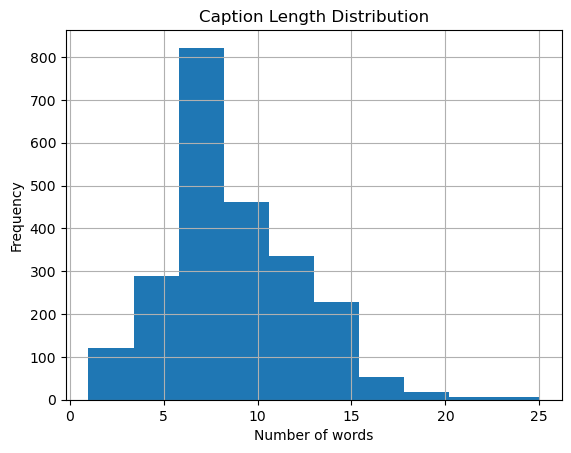

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = ds["train"].to_pandas()

# Example: Distribution of caption lengths
df["caption_length"] = df["caption_choices"].apply(lambda x: len(x.split()))
df["caption_length"].hist()
plt.title("Caption Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()



In [10]:
from collections import Counter

labels = ds["train"]["caption_choices"]
counter = Counter(labels)

len(counter), ds["train"]

(390,
 Dataset({
     features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id'],
     num_rows: 2340
 }))

In [14]:
df = ds['train'].to_pandas()
df.head()

,image,contest_number,image_location,image_description,image_uncanny_description,entities,questions,caption_choices,from_description,label,n_tokens_label,instance_id
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,130,the yard,Two women are looking out a window. There is s...,"A snowman has branches for arms, not human arms.","[https://en.wikipedia.org/wiki/Snowman, https:...",[Is there a man stuck inside?],He has a summer job as a scarecrow.,scene: the yard description: Two women are loo...,The real man inside of the snowman is apparent...,60,62ccf347365fcaad455f9d11267ce10a
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,338,a residential home,A man and a woman are in a room with a regular...,It is unusual to see such a giant book.,"[https://en.wikipedia.org/wiki/Novel, https://...","[Why is the book so big?, What is written in t...",You promised me you would stop after you lost ...,scene: a residential home description: A man a...,The person writing in the giant book only has ...,103,90ec8eabd70643ba4dcbe4c79264a459
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,619,a corporate office,There are two men in suits standing at the doo...,It is unusual for a sword to be sticking out o...,"[https://en.wikipedia.org/wiki/Sword, https://...",[Why is there a sword stuck in an office desk?...,"The pen is mightier, but that looks awesome.",scene: a corporate office description: There a...,"A reference to the saying ""the pen is mightier...",59,d0e7e4deed741964d642361d243f2ecb
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,217,an office room,There is a pool in an office. A man is going t...,There is a huge pool in an office and someone ...,"[https://en.wikipedia.org/wiki/Swimming_pool, ...",[Why is there a pool in an office building?],My wife won't let me put one in the back yard.,scene: an office room description: There is a ...,Couples sometimes argue about whether or not t...,52,351d0ea8e64914291a556dd35bcffdb7
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,711,the living room,3 baseball players appear to be playing baseba...,It's unusual to see games of baseball being pl...,"[https://en.wikipedia.org/wiki/Baseball, https...",[Why are those people playing baseball in a li...,All his pitches have been inside.,scene: the living room description: 3 baseball...,"A play on words. An ""inside pitch"" in baseball...",50,d11cfc0914483e80acfafdb220e9799a


In [17]:
df['caption_choices'].value_counts()

caption_choices
It's curb to table.                                                            6
He has a summer job as a scarecrow.                                            6
You promised me you would stop after you lost your arm from that paper cut!    6
The pen is mightier, but that looks awesome.                                   6
My wife won't let me put one in the back yard.                                 6
                                                                              ..
I'm up here.                                                                   6
I wish they would just go back to tapping our phone lines.                     6
Relax. The DVR is set. You can catch the game tomorrow.                        6
You bought the sofa, you find the remote.                                      6
Look, you agreed to a trial separation.                                        6
Name: count, Length: 390, dtype: int64

In [19]:
selected_cols = ['caption_choices', 'label']

df_train = ds['train'].to_pandas()
df_val = ds['validation'].to_pandas()
df_test = ds['test'].to_pandas()

# Remove duplicates based on those columns
df_train = df_train.drop_duplicates(subset=selected_cols)
df_val = df_val.drop_duplicates(subset=selected_cols)
df_test = df_test.drop_duplicates(subset=selected_cols)

df_train.shape, df_val.shape, df_test.shape

((390, 12), (130, 12), (131, 12))

In [1]:
df_train.columns

NameError: name 'df_train' is not defined

In [ ]:

ds_train = Dataset.from_pandas(df_train)
ds_val = Dataset.from_pandas(df_val)
ds_test = Dataset.from_pandas(df_test)

dataset = DatasetDict({
    "train": ds_train,
    "validation": ds_val,
    "test": ds_test
})

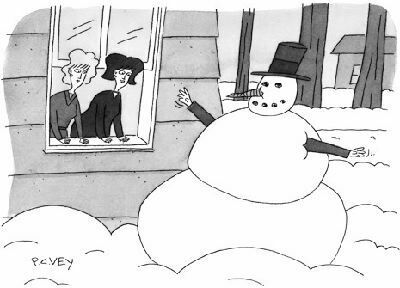

In [28]:
import io

Image.open(io.BytesIO(dataset["train"]["image"][0]['bytes']))

In [30]:
WIDTH, HEIGHT = 100, 100

def preprocess_function(examples):
    # Load and process images
    images = [Image.open(io.BytesIO(image_file['bytes'])).resize((WIDTH, HEIGHT), Image.Resampling.LANCZOS) for image_file in examples['image']]
    # Tokenize captions
    captions = [caption for caption in examples['caption_choices']]
    inputs = processor(images=images, text=captions, return_tensors="pt", padding='max_length', truncation=True)

    # Convert tensors to lists (map expects lists)
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "pixel_values": inputs["pixel_values"],
        "labels": inputs["input_ids"]
    }

# Apply the preprocessing function to the dataset
processed_dataset = dataset.map(preprocess_function, batched=True, batch_size=50, remove_columns=ds["train"].column_names)

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

# Part $3:$ Model Development

In [31]:

training_args = TrainingArguments(
    output_dir="./blip-caption-generator",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=50,
    eval_steps=50,
    save_total_limit=2,
)


In [6]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'pixel_values', 'labels'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'pixel_values', 'labels'],
        num_rows: 60
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'pixel_values', 'labels'],
        num_rows: 50
    })
})

In [32]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
)


In [8]:
trainer.train()


Step,Training Loss
10,9.170300


: 

In [13]:
import torch
import torchvision

ModuleNotFoundError: No module named 'torchvision'

In [8]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("RSRathore/first-repo")
model = AutoModelForImageTextToText.from_pretrained("RSRathore/first-repo")

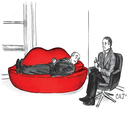

In [10]:
WIDTH, HEIGHT = 128, 128

test_image = ds["test"]["image"][3].convert("RGB").resize((WIDTH, HEIGHT), Image.Resampling.LANCZOS)
context = "This is comical image." #ds["test"]["label"][3] #.convert("RGB").resize((WIDTH, HEIGHT), Image.Resampling.LwwwANCZOS)
test_image

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
test_image = TF.to_tensor(test_image)